In [55]:
from PIL import Image
import torchvision.transforms as transforms
import torch

imageCityscapes = Image.open("photoCityscapes.png").convert("RGB") 
imageGTA = Image.open("photoGTA2.png").convert("RGB") 

transform = transforms.Compose([
    transforms.Resize((512, 1024)),
    transforms.ToTensor(),
])
imageCityscapes_tensor = transform(imageCityscapes)
imageGTA_tensor = transform(imageGTA)
imageCityscapes_tensor = imageCityscapes_tensor.unsqueeze(0)
imageGTA_tensor = imageGTA_tensor.unsqueeze(0)


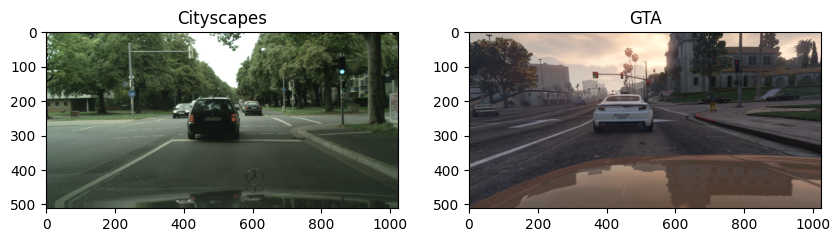

In [56]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(imageCityscapes_tensor[0].permute(1, 2, 0))
ax[0].set_title("Cityscapes")
ax[1].imshow(imageGTA_tensor[0].permute(1, 2, 0))
ax[1].set_title("GTA")
plt.show()

In [57]:
imageCityscapes_tensor.shape, imageGTA_tensor.shape

(torch.Size([1, 3, 512, 1024]), torch.Size([1, 3, 512, 1024]))

In [111]:
import torch

def FDA(src_img: torch.Tensor, tgt_img: torch.Tensor, beta: float = 0.01) -> torch.Tensor:

    # FFT2 is applied to each of the 3 RGB channels
    fft_src = torch.fft.fft2(src_img, dim=(-2, -1))
    fft_tgt = torch.fft.fft2(tgt_img, dim=(-2, -1))

    fft_src_shift = torch.fft.fftshift(fft_src, dim=(-2, -1))
    fft_tgt_shift = torch.fft.fftshift(fft_tgt, dim=(-2, -1))

    _, H, W = src_img.shape
    c_h, c_w = H // 2, W // 2
    bH = int(beta * H/2)
    bW = int(beta * W/2)

    mask = torch.zeros_like(fft_src).real
    mask[:, c_h - bH:c_h + bH, c_w - bW:c_w + bW] = 1
    mask = mask > 0.5

    amplitude_src = torch.abs(fft_src_shift)
    phase_src = torch.angle(fft_src_shift)
    amplitude_tgt = torch.abs(fft_tgt_shift)

    # fft_src = amplitude_src * exp(1j * phase_src)

    a = torch.fft.ifftshift(torch.where(mask, amplitude_tgt, amplitude_src) * torch.exp(1j * phase_src), dim=(-2, -1))
    #a = torch.where(mask, torch.abs(fft_tgt), torch.abs(fft_src)) * torch.exp(1j * torch.angle(fft_src))

    return torch.fft.ifft2(a, dim=(-2, -1)).real.clamp(0, 1)  

In [118]:
# Apply the FDA function
adapted = FDA(imageGTA_tensor[0], imageCityscapes_tensor[0], beta=0.01)

In [119]:
torch.norm(imageGTA_tensor[0] - adapted).item()

144.5925750732422

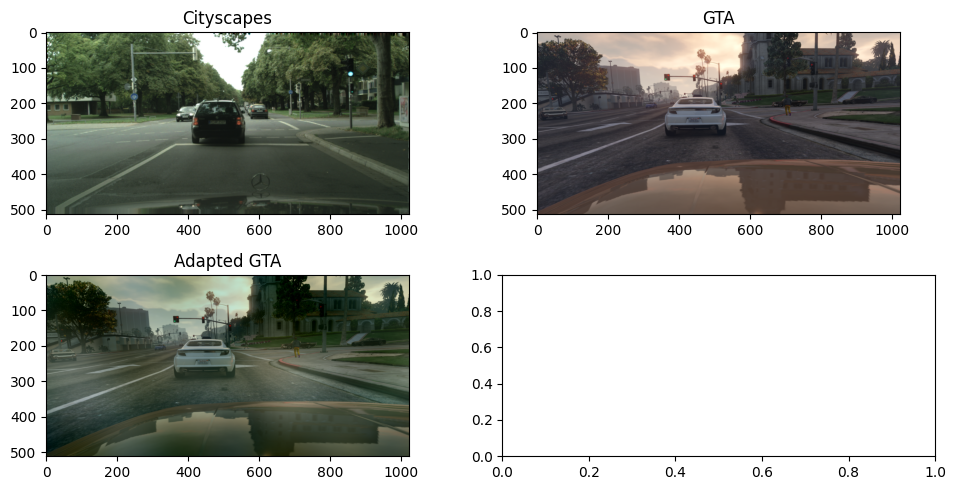

In [120]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0,0].imshow(imageCityscapes_tensor[0].permute(1, 2, 0))
ax[0,0].set_title("Cityscapes")
ax[0,1].imshow(imageGTA_tensor[0].permute(1, 2, 0))
ax[0,1].set_title("GTA")
ax[1,0].imshow(adapted.permute(1, 2, 0))
ax[1,0].set_title("Adapted GTA")
plt.tight_layout()
plt.show()

In [75]:
def FDA(src_img: torch.Tensor, tgt_img: torch.Tensor, beta: float = 0.01) -> torch.Tensor:

    # FFT2 is applied to each of the 3 RGB channels
    # src_img: torch Tensor [B, 3, H, W ]
    # tgt_img: torch Tensor [B, 3, H, W ]
    fft_src = torch.fft.fft2(src_img, dim=(-2, -1))
    fft_tgt = torch.fft.fft2(tgt_img, dim=(-2, -1))

    fft_src_shift = torch.fft.fftshift(fft_src, dim=(-2, -1))
    fft_tgt_shift = torch.fft.fftshift(fft_tgt, dim=(-2, -1))

    _, _, H, W = src_img.shape
    c_h, c_w = H // 2, W // 2
    bH = int(beta * H)
    bW = int(beta * W)

    mask = torch.zeros_like(fft_src).real
    mask[:, :, c_h - bH:c_h + bH, c_w - bW:c_w + bW] = 1
    mask = mask > 0.5

    amplitude_src = torch.abs(fft_src_shift)
    phase_src = torch.angle(fft_src_shift)
    amplitude_tgt = torch.abs(fft_tgt_shift)

    # fft_src = amplitude_src * exp(1j * phase_src)

    # a = torch.fft.ifftshift(torch.where(mask, amplitude_tgt, amplitude_src)* torch.exp(1j * phase_src), dim=(-2, -1))
    a = torch.where(mask, torch.abs(fft_tgt), torch.abs(fft_src)) * torch.exp(1j * torch.angle(fft_src))

    return torch.fft.ifft2(a, dim=(-2, -1)).real.clamp(0, 1)

In [72]:
src = torch.rand(4, 3, 512, 1024)  # batch da 4 immagini RGB
tgt = torch.rand(4, 3, 512, 1024)
out = FDA(src, tgt, beta=0.02)
print(out.shape)  # ➝ torch.Size([4, 3, 512, 1024])


torch.Size([4, 3, 512, 1024])
